In [5]:

# !pip install torch==2.2
# !pip install torchvision==0.17
# !pip install nltk==3.7
# !pip install matplotlib==3.5.2
# !pip install scikit-image==0.19.3

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

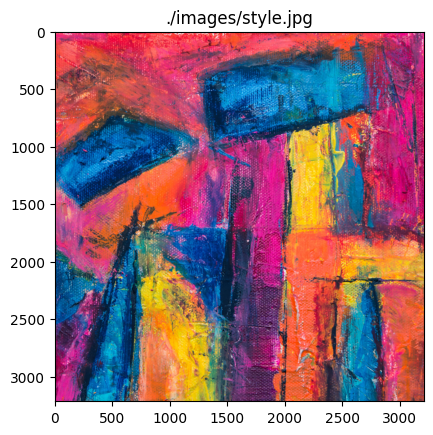

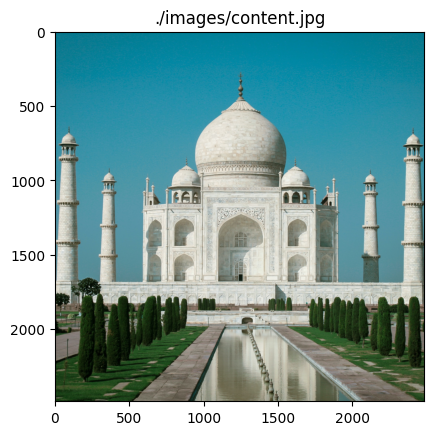

In [7]:
def image_to_tensor(image_path, image_dimension=120):
    img = Image.open(image_path).convert('RGB')
    # display image to check
    plt.figure()
    plt.title(image_path)
    plt.imshow(img)
    if max(img.size) <= image_dimension:
        img_size = max(img.size)
    else:
        img_size = image_dimension

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    return img.to(dvc, torch.float)

style_image = image_to_tensor("./images/style.jpg")
content_image = image_to_tensor("./images/content.jpg")

## we need un-squeeze to add one more dimension

In [8]:
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)

### To calculate the Gram matrix of a 4D feature map tensor, which captures style (texture, patterns, correlations between feature maps).

# pretrained model


In [13]:
vgg19_model = torchvision.models.vgg19(pretrained=True).to(dvc)
print(vgg19_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
vgg19_model = vgg19_model.features  #different in layer info acc to sequential
vgg19_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [16]:
for param in vgg19_model.parameters():
    print(param,'\n')
    param.requires_grad_(False)

Parameter containing:
tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
          [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
          [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],

         [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
          [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
          [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],

         [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
          [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
          [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],


        [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
          [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
          [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],

         [[ 2.8746e-01, -3.3338e-01, -4.5564e-01],
          [ 3.7836e-01, -2.9144e-01, -4.9720e-01],
          [ 5.4778e-01,  4.8983e-01, -1.7166e-01]],

         [[ 6.7260e-02, -9.5386e-02, -3.8037e-02],
          [ 6.1955e-02, -1.3125e-01, -1.0691e-01],
          [ 4.8107e-02,  2.2999e-01, -3.0578e-02]]],


        [[[-3.2457e-02,  1.6281e-01,  5.9687

refine model for this task
change maxpool layers to avgpool

In [17]:
len(vgg19_model)

37

In [32]:
conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size,
                                      stride=vgg19_model[i].stride,
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [33]:
conv_indices

{1: 0,
 2: 2,
 3: 5,
 4: 7,
 5: 10,
 6: 12,
 7: 14,
 8: 16,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 13: 28,
 14: 30,
 15: 32,
 16: 34}

#### clip until the last relevant layer

In [34]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}
layers

{1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

In [35]:
layers.keys()

dict_keys([1, 2, 3, 4, 5])

In [36]:
max(layers.keys())

5

In [37]:
vgg_layers = nn.ModuleList(vgg19_model)
last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]

neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


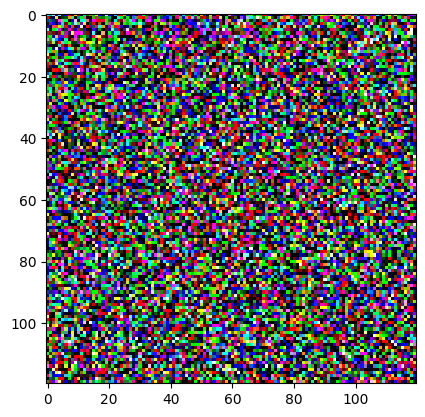

In [38]:
# initialize as the content image
ip_image = content_image.clone()
# initialize as random noise:
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

epoch number 50
style loss = 0.6895759105682373, content loss = 3.1125714778900146


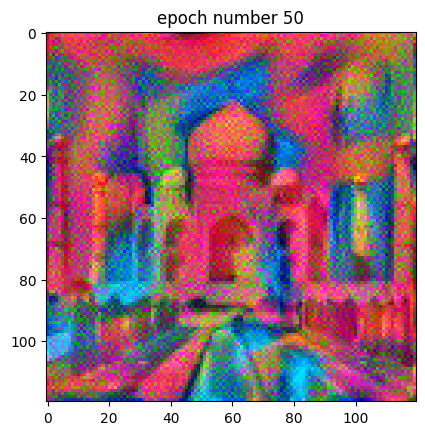

epoch number 100
style loss = 0.45892393589019775, content loss = 2.57838773727417


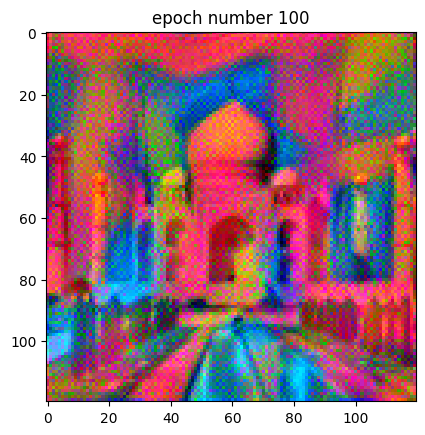

epoch number 150
style loss = 0.7461431622505188, content loss = 3.031155586242676


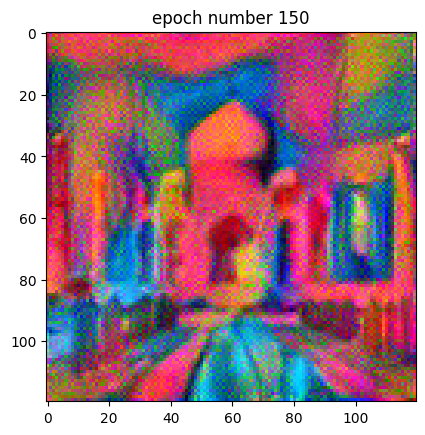

epoch number 200
style loss = 0.3880630433559418, content loss = 2.402817487716675


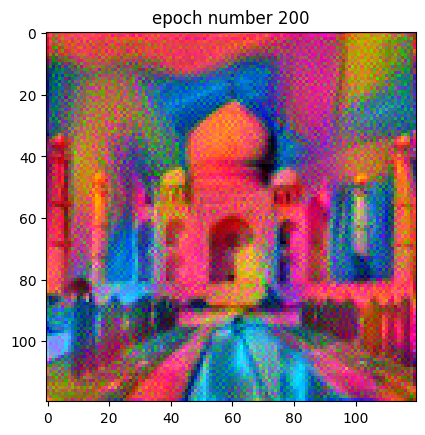

epoch number 250
style loss = 0.3784448802471161, content loss = 2.3348793983459473


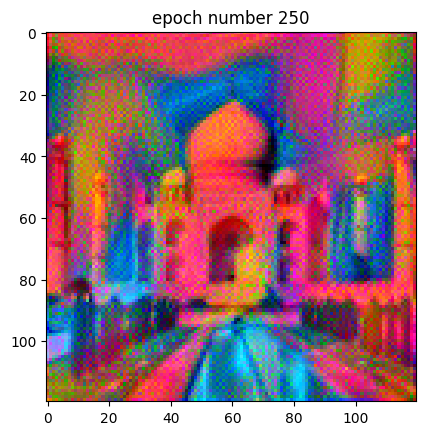

epoch number 300
style loss = 0.3741837739944458, content loss = 2.299896001815796


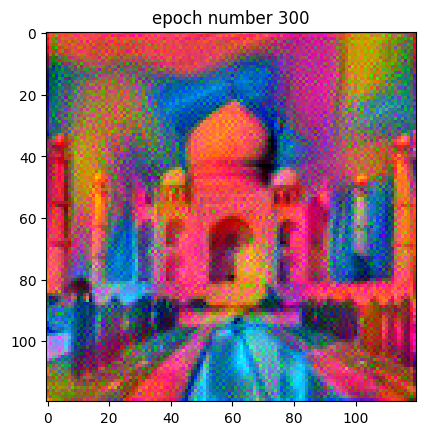

In [40]:
num_epochs = 300
wt_style = 1e6
wt_content = 1
style_losses = []
content_losses = []
opt = optim.Adam([ip_image.requires_grad_()], lr=0.1)

for curr_epoch in range(1, num_epochs+1):
    ip_image.data.clamp_(0, 1)
    opt.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()

    if curr_epoch % 50 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss.item()}, content loss = {epoch_content_loss.item()}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(
            ip_image.data.clamp_(0, 1)
                     .squeeze(0)
                     .cpu()
                     .detach()
                     .numpy()
                     .transpose(1,2,0)
        )
        plt.show()
        style_losses.append(epoch_style_loss.item())
        content_losses.append(epoch_content_loss.item())

    opt.step()
